In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

#Importing Classification algorithms

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    SGDClassifier,
    Perceptron,
    PassiveAggressiveClassifier,
    RidgeClassifier, 
    RidgeClassifierCV
)

from sklearn.svm import LinearSVC, SVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import  GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from rgf.sklearn import RGFClassifier, FastRGFClassifier
from gpboost import GPBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier, 
    GradientBoostingClassifier, 
    ExtraTreesClassifier, 
    IsolationForest, 
    BaggingClassifier, 
    HistGradientBoostingClassifier
)

from imblearn.ensemble import (
    EasyEnsembleClassifier, 
    RUSBoostClassifier, 
    BalancedBaggingClassifier, 
    BalancedRandomForestClassifier 
)

seed = 351

In [2]:
#importing files

X_train = pd.read_csv('X_train_preprocessed.csv')
X_test = pd.read_csv('X_test_preprocessed.csv')

y_train = pd.read_csv('y_train_preprocessed.csv')
y_test = pd.read_csv('y_test_preprocessed.csv')
TEST_DF = pd.read_csv('TEST_DF_preprocessed.csv')

I will create a function that will test majority of classification algorithms on X_train. 

In [3]:
class classif_models:
    
    def __init__(self, Xtrain, ytrain, cv):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.cv = cv
        
    def check_clf_models(self):

        models = [
            LogisticRegression(),
            LogisticRegressionCV(cv=10),
            SGDClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
            Perceptron(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
            PassiveAggressiveClassifier(tol = 0.1, early_stopping = True, validation_fraction = 0.2),
            RidgeClassifier(),
            RidgeClassifierCV(cv=5),
            LinearSVC(loss = 'hinge'),
            SVC(kernel = 'rbf'),
            NuSVC(),
            KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
            GaussianNB(), 
            BernoulliNB(),
            MLPClassifier(tol=0.1, early_stopping = True, validation_fraction = 0.2),
            GaussianProcessClassifier()
        ]

        final_f1_score = []
        final_score = []
        final_score_std = []
        final_roc_auc_score = []
        final_mcc_score = []
        model_names = []

        for model in models:
            pipe = Pipeline(steps = [('scaler', StandardScaler()), (type(model).__name__, model)])
            score = [] 
            f1_score = []
            roc_auc_score = []
            mcc_score = []
            fold_no = 1 
            for train_index, test_index in self.cv.split(self.Xtrain, self.ytrain): 
                X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index] 
                y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index] 
                pipe.fit(X_train_kfold, y_train_kfold) 
                y_pred = pipe.predict(X_val_kfold)
                score.append(metrics.accuracy_score(y_val_kfold, y_pred))
                f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
                mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

                if hasattr(model, "predict_proba"):
                    roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                               pipe.predict_proba(X_val_kfold)[:, 1]))
                else: 
                    roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                               pipe.decision_function(X_val_kfold)))

                fold_no += 1
            final_score.append(np.round(np.mean(score)*100,3))
            final_score_std.append(np.round(np.std(score)*100,3))
            final_f1_score.append(np.round(np.mean(f1_score)*100,3))
            final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
            final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
            model_names.append(type(model).__name__)

    #Using Ensemble Models

        tree_models = [
            DecisionTreeClassifier(criterion = 'entropy', max_depth = 6),
            RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6), 
            XGBClassifier(use_label_encoder=False, eval_metric = 'error'), 
            CatBoostClassifier(verbose = False, loss_function='CrossEntropy', eval_metric='TotalF1'), 
            LGBMClassifier(), 
            AdaBoostClassifier(), 
            GradientBoostingClassifier(), 
            BaggingClassifier(), 
            ExtraTreesClassifier(criterion = 'entropy', max_depth = 6), 
            HistGradientBoostingClassifier(), 
            EasyEnsembleClassifier(), 
            RUSBoostClassifier(), 
            BalancedBaggingClassifier(), 
            BalancedRandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 6), 
            RGFClassifier(loss = 'Log', algorithm='RGF_Sib'), 
            FastRGFClassifier(loss='LOGISTIC'),
            GPBoostClassifier()
        ]

        for model in tree_models:
            score = [] 
            f1_score = []
            mcc_score = []
            fold_no = 1 
            for train_index, test_index in self.cv.split(self.Xtrain,self.ytrain): 
                X_train_kfold, X_val_kfold = self.Xtrain[train_index], self.Xtrain[test_index] 
                y_train_kfold, y_val_kfold = self.ytrain[train_index], self.ytrain[test_index] 
                classifier = model 
                classifier.fit(X_train_kfold, y_train_kfold) 
                y_pred = classifier.predict(X_val_kfold)
                
                score.append(metrics.accuracy_score(y_val_kfold, y_pred))
                
                f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
                
                roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           classifier.predict_proba(X_val_kfold)[:, 1]))
                
                mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

                fold_no += 1
            
            final_score.append(np.round(np.mean(score)*100,3))
            final_score_std.append(np.round(np.std(score)*100,3))
            final_f1_score.append(np.round(np.mean(f1_score)*100,3))
            final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
            final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
            model_names.append(type(model).__name__)


        self.df = pd.DataFrame({
                'Models': model_names, 
                'Accuracy %': final_score, 
                'Acc_STD %': final_score_std, 
                'F1_Score %':final_f1_score,
                'ROC_AUC_Score %' :final_roc_auc_score, 
                'MCC_Score %': final_mcc_score
            }).sort_values('F1_Score %', ascending = False, ignore_index = True).style.\
                                                                highlight_max(color = 'green')

        return self.df

In [4]:
%%time

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

all_models = classif_models(X_train.values, y_train.Loan_Status.values, cv = skf)
all_models.check_clf_models()

Wall time: 2min 37s


,Models,Accuracy %,Acc_STD %,F1_Score %,ROC_AUC_Score %,MCC_Score %
0,BernoulliNB,81.390000,3.392000,87.927000,77.278000,55.155000
1,LogisticRegression,81.586000,4.160000,87.884000,77.937000,55.168000
2,LinearSVC,81.197000,3.580000,87.821000,72.426000,54.573000
3,SVC,81.201000,3.336000,87.653000,76.852000,54.278000
4,ExtraTreesClassifier,81.005000,3.649000,87.645000,75.979000,53.922000
5,RandomForestClassifier,81.205000,3.410000,87.600000,75.735000,54.081000
6,LogisticRegressionCV,81.009000,3.819000,87.541000,77.785000,53.727000
7,RidgeClassifierCV,80.813000,3.605000,87.494000,77.735000,53.453000
8,RidgeClassifier,80.813000,3.605000,87.494000,77.716000,53.453000
9,NuSVC,80.624000,2.822000,87.440000,77.518000,53.071000


At the very top of the above dataframe, the highest possible accuracy from the train set is approximatly 82%. As seen in the previous feature engineering section, **the target variable is highly imbalanced**. Hence, I choose ***F1 score metric*** to evaluate the model. With all the features, the highest *F1 score is around 88.2%*.

In the next sections, I will perform various feature selection techniques in order reduce the number of features and keep only the most significant features in order to have a parsimonious model that can potentially help improve the performance of our models.

# Feature Selection

#### Correlation Matrix

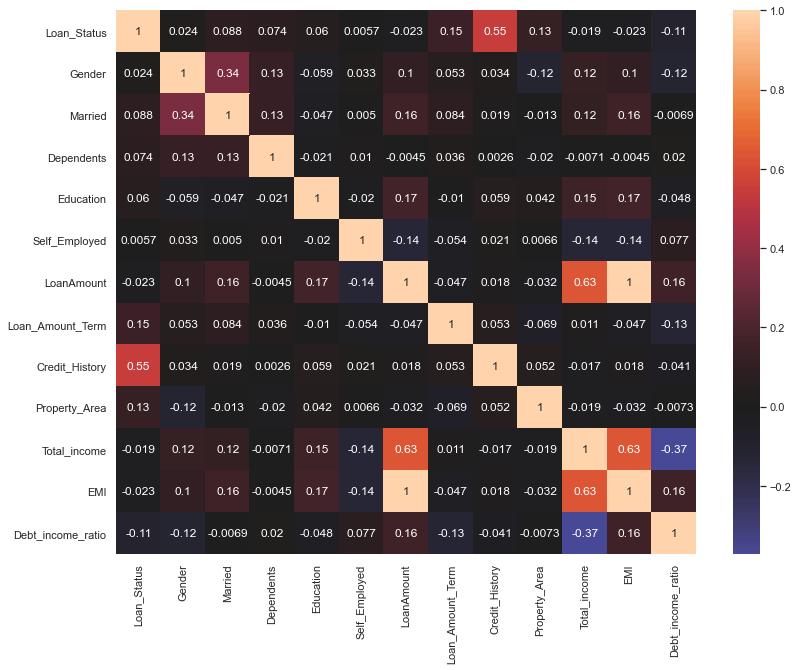

In [5]:
plt.figure(figsize = (13,10))
sns.heatmap(pd.concat([y_train, X_train], axis = 1).corr(), annot = True, center = 0);

From the correlation matrix, we can deduce the following:

1. Most of the features have very low correlation with the target variable, *'Loan Status'*, except for Credit history, having a positive correlation of around 55%. <br>
<br>
2. There are feature that are correlated, which suggests that there are multicollinearity between features. Hence most of the features might not be suitable for linear models.

#### Mutual Information

Index(['Gender', 'Credit_History', 'Property_Area', 'Debt_income_ratio'], dtype='object')

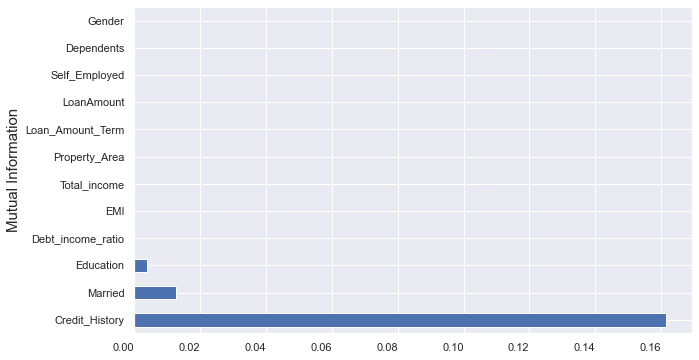

In [6]:
# to obtain the mutual information values
from sklearn.feature_selection import mutual_info_classif

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile

mi = mutual_info_classif(X_train, y_train.Loan_Status)

# 1) let's capture the above array in a pandas series
# 2)add the variable names in the index
# 3) sort the features based on their mutual information value
# 4) and make a var plot

mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False).plot.barh(figsize=(10, 6));
plt.xticks(ha = 'right')
plt.ylabel('Mutual Information');

# select features
sel_ = SelectKBest(mutual_info_classif, k=4).fit(X_train, y_train.Loan_Status)

# display features

mi_feat = X_train.columns[sel_.get_support()]
mi_feat

#### Chi - Squared

In [8]:
# from sklearn.feature_selection import SelectKBest, chi2

# sel_ = SelectKBest(chi2, k=4).fit(X_train, y_train.Loan_Status)

# pd.DataFrame({'Score': sel_.scores_}, index=X_train.columns).\
# sort_values('Score', ascending = False).plot(kind = 'barh', figsize = (10,5));
# plt.xticks(ha='right');

# chi2_feat = X_train.columns[sel_.get_support()]
# chi2_feat

#### ANOVA

Index(['Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Debt_income_ratio'],
      dtype='object')

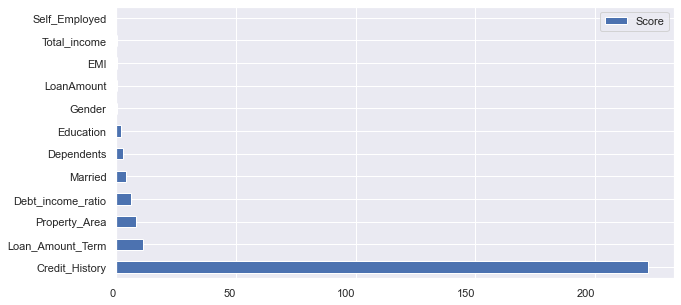

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif #or f_regression for regression. #ANOVA

sel_ = SelectKBest(f_classif, k=4).fit(X_train, y_train.Loan_Status)
pd.DataFrame({'Score': sel_.scores_}, index=X_train.columns).\
sort_values('Score', ascending = False).plot(kind = 'barh', figsize = (10,5));
plt.xticks(ha='right');

anova_feat = X_train.columns[sel_.get_support()]
anova_feat

#### Feature importance using Random Forest

#### Wrapper methods

In [13]:
%%time

#BAckward Elimination
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

# model = Pipeline(
#     [('scaler', StandardScaler()), 
#     ('logit_CV', LogisticRegressionCV(cv=10))]
# )

back = SFS(model, k_features=(1,11),forward=False, floating=False, scoring = 'roc_auc', 
           cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle = True))

back.fit(X_train, y_train)

print(f'Best Score: {np.round(back.k_score_*100,3)} %')
back.k_feature_names_

Best Score: 79.339 %
Wall time: 1min 13s


('Gender',
 'Married',
 'Dependents',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Debt_income_ratio')

In [14]:
%%time

#Forward Elimination
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

# model = Pipeline(
#     [('scaler', StandardScaler()), 
#     ('logit_CV', LogisticRegressionCV(cv=10))]
# )

front = SFS(model, k_features=(1,11), scoring = 'roc_auc', forward=True, 
            floating=False, cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle = True))

front.fit(X_train, y_train)

print(f'Best Score: {np.round(front.k_score_*100,3)} %')
front.k_feature_names_

Best Score: 79.552 %
Wall time: 1min 10s


('Married',
 'Dependents',
 'LoanAmount',
 'Credit_History',
 'Property_Area',
 'EMI',
 'Debt_income_ratio')

In [17]:
%%time

#Bidirectional Elimination
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

# model = Pipeline(
#     [('scaler', StandardScaler()), 
#     ('logit_CV', LogisticRegressionCV(cv=10))]
# )

bi = SFS(model, k_features=(1,11), scoring = 'roc_auc', forward=True, 
         floating=True, cv=StratifiedKFold(n_splits=10, random_state=seed, shuffle = True))

bi.fit(X_train, y_train)

print(f'Best Score: {np.round(bi.k_score_*100,3)} %')
bi.k_feature_names_

Best Score: 79.734 %
Wall time: 3min 34s


('Gender',
 'Married',
 'Dependents',
 'Credit_History',
 'Property_Area',
 'EMI',
 'Debt_income_ratio')

#### Embedded methods¶


,Features,Score
7,Credit_History,0.224926
6,Loan_Amount_Term,0.029519
8,Property_Area,0.023453
1,Married,0.010700
2,Dependents,0.010052
3,Education,0.002083
10,EMI,0.000373
4,Self_Employed,0.000007
5,LoanAmount,-0.000040
0,Gender,-0.000888


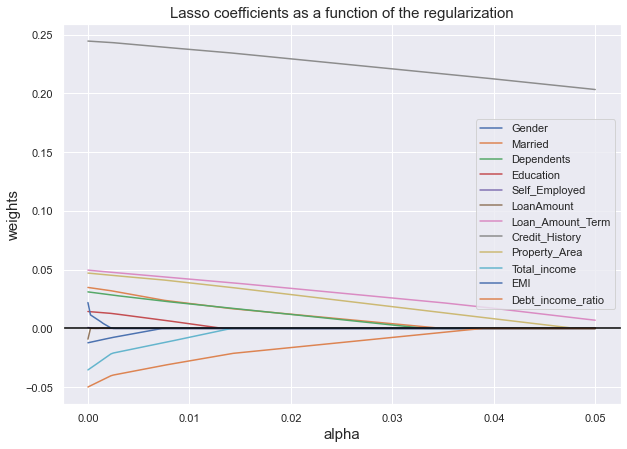

In [18]:
#Using LASSO regularization 

from sklearn import linear_model
# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.linspace(-0.0,0.05,n_alphas)#10**np.linspace(10,-2,n_alphas)*0.5

coefs = []
for a in alphas:
    lasso = Pipeline(steps = [
        ('scaler', StandardScaler()), 
        ('lasso', linear_model.Lasso(alpha=a, fit_intercept=False))
    ])
    
    lasso.fit(X_train, y_train)
    coefs.append(lasso.named_steps.lasso.coef_)

# #############################################################################
# Display results
label = X_train.columns

plt.figure(figsize = (10,7))
ax = plt.gca()
ax.plot(alphas, coefs);

plt.axhline(y=0, color='black', linestyle='-')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(label);

coef_df = pd.DataFrame({'Features': label, 'Score':np.mean(coefs,0)})

coef_df.sort_values('Score', ascending = False)

In [19]:
lasso_feat = ['Credit_History', 'Loan_Amount_Term', 'Property_Area', 'Debt_income_ratio']

Features ranked according to Extra Trees Feature Importance: Index(['Credit_History', 'Debt_income_ratio', 'Property_Area',
       'Loan_Amount_Term'],
      dtype='object')
Wall time: 131 ms


,Score
Gender,0.015383
Married,0.023140
Dependents,0.028075
Education,0.013018
Self_Employed,0.014694
LoanAmount,0.032893
Loan_Amount_Term,0.042215
Credit_History,0.655150
Property_Area,0.042302
Total_income,0.035529


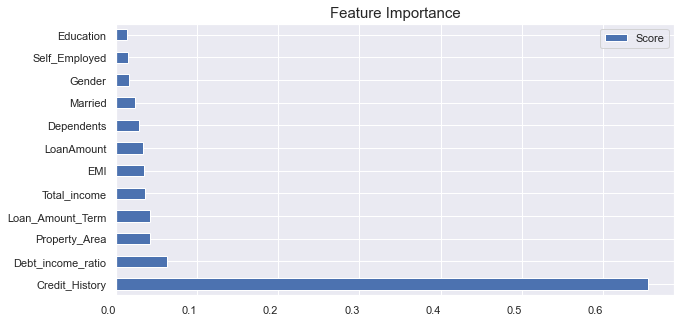

In [21]:
%%time

#Feature Importance

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

model.fit(X_train, y_train)

fi_df = pd.DataFrame({'Score': model.feature_importances_}, index=X_train.columns)

fi_df.sort_values('Score', ascending = False).plot(kind = 'barh', figsize = (10,5), 
                                                   title = 'Feature Importance');
plt.xticks(ha='right');

et_fi_feat = fi_df.sort_values('Score', ascending = False)[:4].index
print(f'Features ranked according to Extra Trees Feature Importance: {et_fi_feat}')

fi_df

#### Recursive Feature Elimination

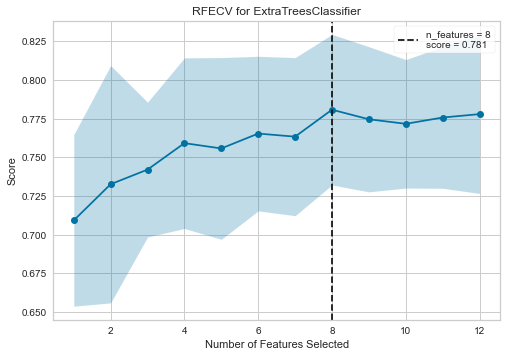

Feature Rankings: [3 2 1 4 5 1 1 1 1 1 1 1]
Wall time: 1min 11s


In [22]:
%%time

from yellowbrick.model_selection import RFECV

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

visualizer = RFECV(model, 
                   cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle = True), 
                   scoring = 'roc_auc')

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show();           # Finalize and render the figure
   
print(f'Feature Rankings: {visualizer.ranking_}')

rfe_feat = [X_train.columns[i] for i, x in enumerate(visualizer.ranking_) if x==1]

#### Recursive Feature Addition

Score when using all features: 77.689 %


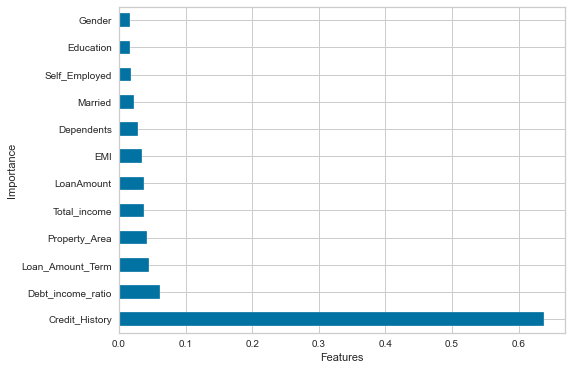

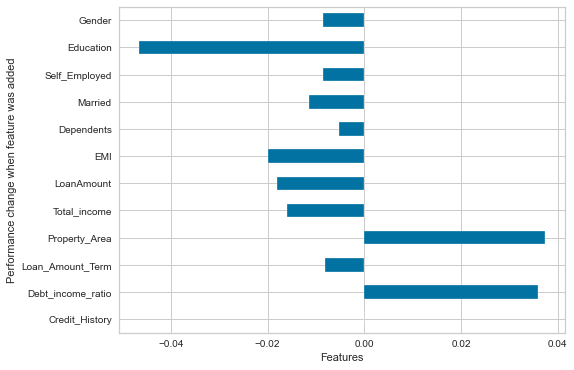

Selected Features: ['Credit_History', 'Property_Area', 'Debt_income_ratio']
Wall time: 13.8 s


In [23]:
%%time

from feature_engine.selection import RecursiveFeatureAddition

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

rfa = RecursiveFeatureAddition(
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='roc_auc',  # the metric we want to evalute
    threshold=0.0001,  # the minimum performance increase needed to select a feature
    cv=10,  # cross-validation
)

rfa.fit(X_train, y_train)

print(f'Score when using all features: {np.round(rfa.initial_model_performance_*100,3)} %')

# importance of all features based of initial model
rfa.feature_importances_.plot.barh(figsize=(8,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

pd.Series(rfa.performance_drifts_).plot.barh(figsize=(8,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

rfa_feat = [feat for feat in X_train.columns if feat not in rfa.features_to_drop_]

print(f'Selected Features: {rfa_feat}')

Score when using all features: 76.934 %


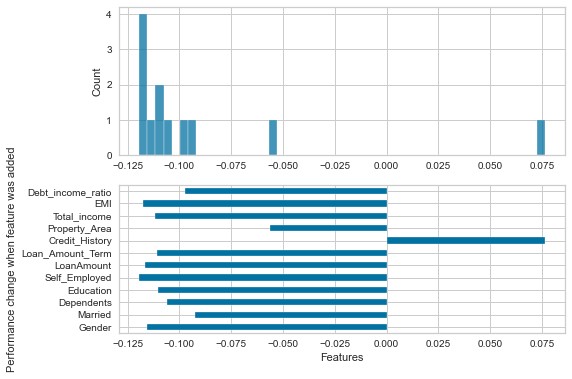

Selected Features: ['Credit_History', 'Property_Area']
Wall time: 3.06 s


In [24]:
%%time

from feature_engine.selection import SelectByShuffling

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

sel_shuff = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=model, # the ML model
    scoring='roc_auc', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=10, # cross validation
    random_state=seed # seed
)

sel_shuff.fit(X_train, y_train)

print(f'Score when using all features: {np.round(sel_shuff.initial_model_performance_*100,3)} %')

fig, ax = plt.subplots(2,1)

sns.histplot(sel_shuff.performance_drifts_, bins = 50, ax=ax[0])

pd.Series(sel_shuff.performance_drifts_).plot.barh(figsize=(8,6));
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

sel_shuff_feat = [feat for feat in X_train.columns if feat not in sel_shuff.features_to_drop_]

print(f'Selected Features: {sel_shuff_feat}')

In [49]:
%%time
from boruta import BorutaPy

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6, class_weight='balanced', n_jobs = -1)

feat_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=seed)

feat_selector.fit(X_train.values, y_train.Loan_Status.values)

print(f'Selected Features: {feat_selector.support_}')
print()
print(f'Feature Ranking: {feat_selector.ranking_}')
print()
boruta_feat = [X_train.columns[i] for i, feat in enumerate(feat_selector.ranking_) if feat==1]

Selected Features: [False False False False False False  True  True  True False False  True]

Feature Ranking: [9 4 6 7 8 2 1 1 1 5 3 1]

Wall time: 7.97 s


# Comparison of all Feature Selection techniques

In [50]:
selected_features = {
    'mutual_information': mi_feat, 
#     'chi_squared': chi2_feat, 
    'ANOVA': anova_feat, 
    'back_elimination': list(back.k_feature_names_), 
    'front_elimination': list(front.k_feature_names_),
    'bidirectional_elimination': list(bi.k_feature_names_),
    'LASSO_regularization': lasso_feat, 
    'ExtraTrees_feature_imp': et_fi_feat, 
    'recursive_feature_elimination': rfe_feat, 
    'recursive_feature_addition': rfa_feat, 
    'select_by_shuffle': sel_shuff_feat, 
    'Boruta': boruta_feat
}

In [51]:
def check_features(model, train_X, train_Y, feature_dict, cv):
    
    final_f1_score = []
    final_score = []
    final_score_std = []
    final_roc_auc_score = []
    final_mcc_score = []
    feat_names = []

    for name, feat in feature_dict.items():
        
        Xtrain = train_X.loc[:,feat].values
        ytrain = train_Y.values

        score = [] 
        f1_score = []
        roc_auc_score = []
        mcc_score = []
        fold_no = 1 

        for train_index, test_index in cv.split(Xtrain, ytrain): 
            X_train_kfold, X_val_kfold = Xtrain[train_index], Xtrain[test_index] 
            y_train_kfold, y_val_kfold = ytrain[train_index], ytrain[test_index] 
            classifier = model 
            classifier.fit(X_train_kfold, y_train_kfold) 
            y_pred = classifier.predict(X_val_kfold)
            score.append(metrics.accuracy_score(y_val_kfold, y_pred))
            f1_score.append(metrics.f1_score(y_val_kfold, y_pred))
            roc_auc_score.append(metrics.roc_auc_score(y_val_kfold, 
                                                           classifier.predict_proba(X_val_kfold)[:, 1]))
            mcc_score.append(metrics.matthews_corrcoef(y_val_kfold, y_pred))

            fold_no += 1

        final_score.append(np.round(np.mean(score)*100,3))
        final_score_std.append(np.round(np.std(score)*100,3))
        final_f1_score.append(np.round(np.mean(f1_score)*100,3))
        final_roc_auc_score.append(np.round(np.mean(roc_auc_score)*100,3))
        final_mcc_score.append(np.round(np.mean(mcc_score)*100,3))
        feat_names.append(name)
    
    df = pd.DataFrame({
        'Feature Selection Method': feat_names, 
        'Accuracy %': final_score, 
        'Acc_STD %': final_score_std, 
        'F1_Score %':final_f1_score,
        'ROC_AUC_Score %' :final_roc_auc_score, 
        'MCC_Score %': final_mcc_score
    }).sort_values('ROC_AUC_Score %', ascending = False, ignore_index = True).style.\
                                                        highlight_max(color = 'green')
        
    return df


In [52]:
%%time

model = ExtraTreesClassifier(criterion = 'entropy', max_depth = 6)

# model = Pipeline(
#     [('scaler', StandardScaler()), 
#     ('logit_CV', LogisticRegressionCV(cv=10))]
# )

check_features(model, 
               X_train, 
               y_train, 
               feature_dict = selected_features, 
               cv = StratifiedKFold(n_splits=10, random_state=seed, shuffle = True))

Wall time: 10.6 s


,Feature Selection Method,Accuracy %,Acc_STD %,F1_Score %,ROC_AUC_Score %,MCC_Score %
0,bidirectional_elimination,81.390000,3.603000,87.898000,79.094000,55.020000
1,front_elimination,81.197000,3.580000,87.789000,78.698000,54.536000
2,recursive_feature_addition,81.967000,3.290000,88.151000,78.610000,56.447000
3,back_elimination,81.197000,3.475000,87.750000,78.572000,54.504000
4,mutual_information,81.970000,3.369000,88.123000,78.333000,56.391000
5,recursive_feature_elimination,81.197000,3.475000,87.784000,78.279000,54.573000
6,LASSO_regularization,81.586000,3.688000,87.913000,77.381000,55.251000
7,ANOVA,81.586000,3.688000,87.913000,77.202000,55.251000
8,Boruta,81.586000,3.688000,87.913000,77.059000,55.251000
9,ExtraTrees_feature_imp,81.586000,3.688000,87.913000,76.974000,55.251000


In [34]:
%%time

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)

all_models = classif_models(X_train.loc[:, front.k_feature_names_].values, 
                            y_train.Loan_Status.values, 
                            cv = skf)

all_models.check_clf_models()

Wall time: 2min 2s


,Models,Accuracy %,Acc_STD %,F1_Score %,ROC_AUC_Score %,MCC_Score %
0,GaussianProcessClassifier,82.540000,2.730000,88.370000,78.202000,58.046000
1,SVC,81.967000,2.933000,88.230000,76.651000,56.651000
2,GaussianNB,81.774000,3.408000,88.078000,76.790000,56.172000
3,ExtraTreesClassifier,81.582000,3.512000,88.008000,74.696000,55.565000
4,RandomForestClassifier,81.778000,3.485000,87.986000,75.737000,55.754000
5,LinearSVC,81.197000,3.580000,87.821000,69.940000,54.573000
6,BernoulliNB,81.197000,3.580000,87.821000,77.154000,54.573000
7,NuSVC,81.005000,2.852000,87.730000,77.115000,54.258000
8,LogisticRegressionCV,81.005000,3.649000,87.679000,77.837000,53.991000
9,RidgeClassifier,81.005000,3.649000,87.679000,77.807000,53.991000


Therefore, from 12 features the following features gives the best performance for the model.

* 'Married',
* 'Dependents',
* 'LoanAmount',
* 'Credit_History',
* 'Property_Area',
* 'EMI',
* 'Debt_income_ratio'

In [36]:
X_train_pars = X_train.loc[:, front.k_feature_names_]
X_test_pars = X_test.loc[:, front.k_feature_names_]
TEST_DF_pars = TEST_DF.loc[:, front.k_feature_names_]

In [39]:
X_train_pars.to_csv('X_train_pars.csv', index = False)
X_test_pars.to_csv('X_test_pars.csv', index = False)
TEST_DF_pars.to_csv('TEST_DF_pars.csv', index = False)